In [16]:
import seaborn as sn
import pandas as pd
import json, os

import torch
import torch.nn as nn
import numpy as np
import csv
from transformers import AutoTokenizer, AutoModel, BertConfig
from transformers import AdamWeightDecay
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

from tqdm.notebook import tqdm


Define method name and root path of the repository

In [3]:
method = "forSequence"

root_path = os.path.join('..', '..', '..')

Define specific seeder for all experiments and processes

In [4]:
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

Define functions for data read and preparation

In [5]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 


Read data and shuffle them

In [48]:
# data_reduced_bert # bigvul_data_reduced
with open(os.path.join(root_path, 'data', 'data_reduced_bert.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)
random.shuffle(data) # shuffle the data

# Data preparation
texts, labels, headlines = prepareData(data)

In [49]:
data[0]

['test_constants.py',
 '0',
 '__metaclass__',
 'type',
 '@pytest',
 'fixture',
 'def',
 'StringIO',
 'strId$',
 'defaults',
 'strId$',
 'strId$',
 'strId$',
 'p',
 'configparser',
 'ConfigParser',
 'p',
 'return',
 'p',
 '@pytest',
 'fixture',
 'def',
 'user',
 'user',
 'user',
 'strId$',
 'os',
 'pwd',
 'user',
 'strId$',
 'user',
 'strId$',
 'user',
 'strId$',
 'return',
 'user',
 '@pytest',
 'fixture',
 'def',
 'cfg_file',
 'data',
 'strId$',
 'constants',
 'CONFIG_FILE',
 'constants',
 'CONFIG_FILE',
 'os',
 'path',
 'join',
 'data',
 'strId$',
 'yield',
 'data',
 'constants',
 'CONFIG_FILE',
 '@pytest',
 'fixture',
 'def',
 'constants',
 'CONFIG_FILE',
 'del',
 'constants',
 'CONFIG_FILE',
 'yield',
 'constants',
 'CONFIG_FILE',
 '@pytest',
 'fixture',
 'def',
 'cwd',
 'data',
 'strId$',
 'old_cwd',
 'os',
 'getcwd',
 'os',
 'getcwd',
 'lambda',
 'data',
 'None',
 'if',
 'hasattr',
 'os',
 'strId$',
 'os',
 'os',
 'lambda',
 'to_text',
 'data',
 'yield',
 'data',
 'os',
 'getcwd',

Data visualization

Elements in dataset: 4184
2 categories found:
0
1


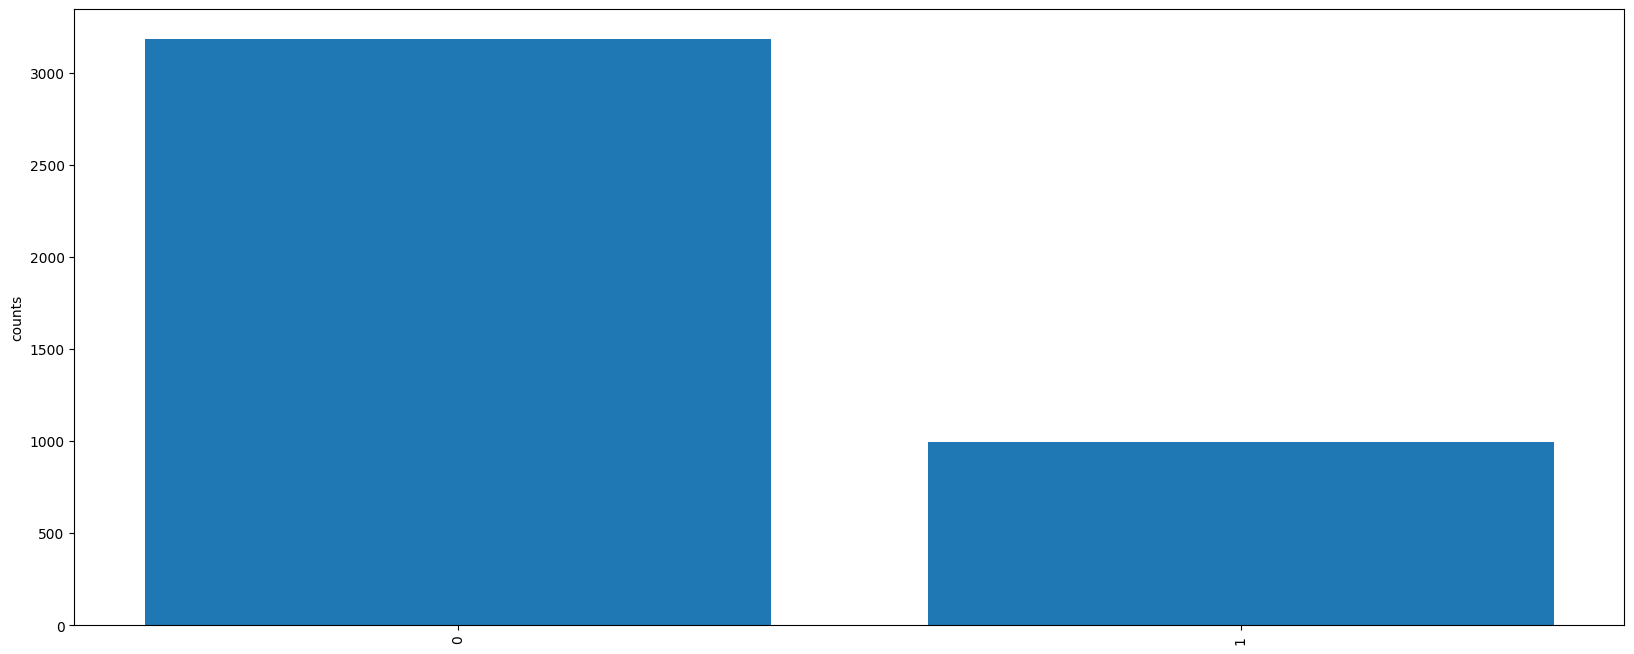

In [50]:
# explore data
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [51]:
data = pd.DataFrame(({'Input': texts, 'Is_Vulnerable': labels}))
data = data[0:100]
data.head()

,Input,Is_Vulnerable
0,__metaclass__ type @pytest fixture def stringi...,0
1,if strid$ not in sys path sys path insert numi...,0
2,sys path insert numid$ os path dirname __file_...,1
3,__metaclass__ type ansible_metadata strid$ str...,0
4,__metaclass__ type class basefactcollector nam...,0


Train test split with seeder

In [52]:
val_ratio = 0.10

#split to train-val-test
# split dataset to train-test sets
### split data into train and test (90% train, 10% test)
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

train_data, test_data = train_test_split(data, test_size=val_ratio, random_state=shuffle_seeder, stratify=data['Is_Vulnerable'])
# print(len(data))
# print(len(train_data))
# print(len(test_data))
# print(len(test_data)+len(train_data))

In [53]:
train_data, val_data = train_test_split(train_data, test_size=val_ratio, random_state=shuffle_seeder, stratify=train_data['Is_Vulnerable'])

Pre-processing step: Under-sampling

In [54]:
sampling = True
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Is_Vulnerable"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2) 
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Input"]).reshape(-1, 1), train_data["Is_Vulnerable"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Input"]
    Y_train = train_data["Is_Vulnerable"]

Class distribution  0    65
1    16
Name: Is_Vulnerable, dtype: int64
Majority class  0
Minority class  1
Targeted number of majority class 16
Class distribution after augmentation 0    16
1    16
Name: Is_Vulnerable, dtype: int64


Choose transformer model

In [55]:
model_variation = "microsoft/codebert-base-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base # microsoft/codebert-base-mlm # microsoft/codebert-base

Insert new tokens to the tokenizer

In [56]:
# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)


In [57]:
# config = BertConfig(dropout=0.2, attention_dropout=0.2)
# pre_model = AutoModel.from_pretrained(model_variation, num_labels=n_categories, config=config)
pre_model = AutoModel.from_pretrained(model_variation, num_labels=n_categories)

pre_model.resize_token_embeddings(len(tokenizer))

Embedding(50267, 768)

Find the max length of the tokined input sequneces of the training set

In [58]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    max_row = 0
    
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Convert input_ids to a PyTorch tensor
        input_ids_tensor = torch.tensor(input_ids)
        # Calculate the length of the tokenized sequence for the current sample
        length = torch.sum(input_ids_tensor != tokenizer.pad_token_id).item()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)
    
    return max_length

In [59]:
X = tokenizer(
        text=X_train.tolist(),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

max_len = getMaxLen(X)
print("Max tokenized length", max_len)

Max length of tokenized data: 512
Row with max length: 3
Max tokenized length 512


C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_7096\514096298.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_tensor = torch.tensor(input_ids)


Tokenize train and test sets

In [60]:
def tokenize_X(x_train, x_val, x_test, max_len):
    
    X_train = tokenizer(
        text=x_train.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    X_val = tokenizer(
        text=x_val.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    
    X_test = tokenizer(
        text=x_test.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    
    return X_train, X_val, X_test

In [61]:
X_train, X_val, X_test = tokenize_X(X_train, val_data['Input'], test_data['Input'], max_len)

Aternative way using batch encoding

In [62]:
# def encode(docs, max_len):
#     '''
#     This function takes list of texts and returns input_ids and attention_mask of texts
#     '''
#     encoded_dict = tokenizer.batch_encode_plus(docs.tolist(), add_special_tokens=True, max_length=max_len, padding=True,
#                             return_attention_mask=True, truncation=True, return_token_type_ids=False, return_tensors='pt', verbose=True)
    
#     return encoded_dict

# X_train = encode(X_train, max_len)
# #X_val = encode(val_data['Input'], max_len)
# X_test = encode(test_data['Input'], max_len)

In [63]:
Y_train = torch.LongTensor(Y_train.tolist())
Y_val = torch.LongTensor(val_data["Is_Vulnerable"].tolist())
Y_test = torch.LongTensor(test_data["Is_Vulnerable"].tolist())
Y_train.size(), Y_val.size(), Y_test.size()

(torch.Size([32]), torch.Size([9]), torch.Size([10]))

In [64]:
batch_size = 6 #16

train_dataset = TensorDataset(X_train["input_ids"], X_train["attention_mask"], Y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(X_val["input_ids"], X_val["attention_mask"], Y_val)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(X_test["input_ids"], X_test["attention_mask"], Y_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Add classification head

In [80]:
class BertClassification(nn.Module):
    def __init__(self, pre_model, n_categories):
        super(BertClassification, self).__init__()
        self.bert = pre_model
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768, 64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64, n_categories)
        
    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        return logits
        
model = BertClassification(pre_model, n_categories)

Select Hyper-parameters

In [81]:
n_epochs = 100
patience = 5
lr = 5e-4 #5e-05 #  5e-5, 3e-5, 2e-5

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*n_epochs )


Training

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [83]:
print(model.to(device))
total_params = sum(p.numel() for p in model.parameters())
total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

BertClassification(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-0

In [84]:
def save_checkpoint(filename, epoch, model, optimizer, scheduler, train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_per_epoch': train_loss_per_epoch,
        'val_loss_per_epoch': val_loss_per_epoch,
        'train_f1_per_epoch': train_f1_per_epoch,
        'val_f1_per_epoch': val_f1_per_epoch
        }
    torch.save(state, filename)

In [85]:
# # we do not retrain our pre-trained BERT and train only the last linear dense layer
# for param in model.bert_model.parameters():
#     param.requires_grad = False

In [86]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

# Initialize values for implementing Callbacks
## Early Stopping
best_val_f1 = -1
best_epoch = -1
no_improvement_counter = 0
## Save best - optimal checkpointing
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, 'best_weights.pt')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_f1_per_epoch = []
val_f1_per_epoch = []

for epoch_num in range(n_epochs):
    print('Epoch: ', epoch_num + 1)
    
    #Training
    model.train()
    train_loss = 0
    total_preds = []
    total_labels = []
    for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
        
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        
        # clear previously calculated gradients
        model.zero_grad() # optimizer.zero_grad()
        
        # get model predictions for the current batch
        output = model(input_ids = input_ids, attention_mask = att_mask) # , labels=labels
        
        # compute the loss between actual and predicted values
        loss = nn.CrossEntropyLoss()(output, labels) #loss = output.loss #output[0]       
        # add on to the total loss
        train_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
        # update parameters
        optimizer.step()
        scheduler.step()
        
        # Print training loss after each batch
        #print("Epoch {}/{} - Batch {}/{} - Training Loss: {:.4f}".format(epoch_num+1, n_epochs, step_num+1, len(train_dataloader), loss.item()))
        
        # model predictions are stored on GPU. So, push it to CPU
        preds = np.argmax(output.cpu().detach().numpy(),axis=-1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()
        
    train_loss_per_epoch.append(train_loss / len(train_dataloader))    
    train_accuracy=accuracy_score(total_labels, total_preds)
    if n_categories > 2:
        train_precision=precision_score(total_labels, total_preds, average='macro')
        train_recall=recall_score(total_labels, total_preds, average='macro')
        train_f1=f1_score(total_labels, total_preds, average='macro')
    else:
        train_precision=precision_score(total_labels, total_preds)
        train_recall=recall_score(total_labels, total_preds)
        train_f1=f1_score(total_labels, total_preds)
        train_roc_auc=roc_auc_score(total_labels, total_preds)
    train_f2 = (5*train_precision*train_recall) / (4*train_precision+train_recall)

    #Validation
    model.eval()
    valid_loss = 0
    valid_pred = []
    actual_labels = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(val_dataloader, desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            
            output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
            
            preds = np.argmax(output.cpu().detach().numpy(),axis=-1)
            valid_pred+=list(preds)
            actual_labels+=labels.tolist()

            loss = nn.CrossEntropyLoss()(output, labels) #loss = output.loss #output[0]
            valid_loss += loss.item()
        
    val_loss_per_epoch.append(valid_loss / len(val_dataloader))    
    val_accuracy=accuracy_score(actual_labels, valid_pred)
    if n_categories > 2:
        val_precision=precision_score(actual_labels, valid_pred, average='macro')
        val_recall=recall_score(actual_labels, valid_pred, average='macro')
        val_f1=f1_score(actual_labels, valid_pred, average='macro')
    else:
        val_precision=precision_score(actual_labels, valid_pred)
        val_recall=recall_score(actual_labels, valid_pred)
        val_f1=f1_score(actual_labels, valid_pred)
        val_roc_auc=roc_auc_score(actual_labels, valid_pred)
    val_f2 = (5*val_precision*val_recall) / (4*val_precision+val_recall)
    
    print("Epoch {}/{} - Train Loss: {:.4f} - Valid Loss: {:.4f}".format(epoch_num+1, n_epochs, train_loss_per_epoch[-1], val_loss_per_epoch[-1]))
    print("Epoch {}/{} - Train F1: {:.4f} - Valid F1: {:.4f}".format(epoch_num+1, n_epochs, train_f1, val_f1))
    
    train_f1_per_epoch.append(train_f1)
    val_f1_per_epoch.append(val_f1)
    
    # Implement Callbacks: Early Stopping and save best
    # Check if the validation F1 score has improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch_num + 1
        no_improvement_counter = 0 # Reset the counter
        
        # Save the best model checkpoint
        save_checkpoint(save_path, epoch_num+1, model.state_dict(), optimizer.state_dict(), scheduler.state_dict(), train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch)
        print("Model saved at epoch: ", epoch_num+1)
    else:
        no_improvement_counter += 1
        
        if no_improvement_counter >= patience:
            print("No improvement for", patience, "consecutive epochs.")
            total_epochs = epoch_num + 1
            print("Early stopping after epoch No.", total_epochs)
            print("Best model after epoch No", best_epoch)
            print("Best achieved val_f1 = ", best_val_f1)
            break

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch:  1


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.8017 - Valid Loss: 0.8212
Epoch 1/100 - Train F1: 0.6522 - Valid F1: 0.3636
Model saved at epoch:  1
Epoch:  2


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.7226 - Valid Loss: 0.6181
Epoch 2/100 - Train F1: 0.6222 - Valid F1: 0.0000
Epoch:  3


D:\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_7096\2898152327.py:103: RuntimeWarning: invalid value encountered in double_scalars
  val_f2 = (5*val_precision*val_recall) / (4*val_precision+val_recall)


Training:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

Plot history

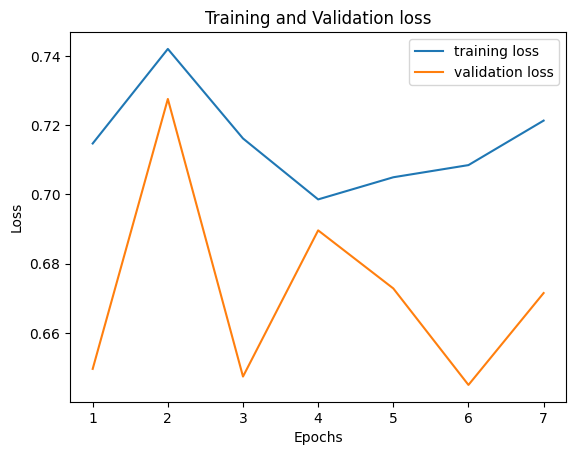

In [145]:
epochs = range(1, total_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

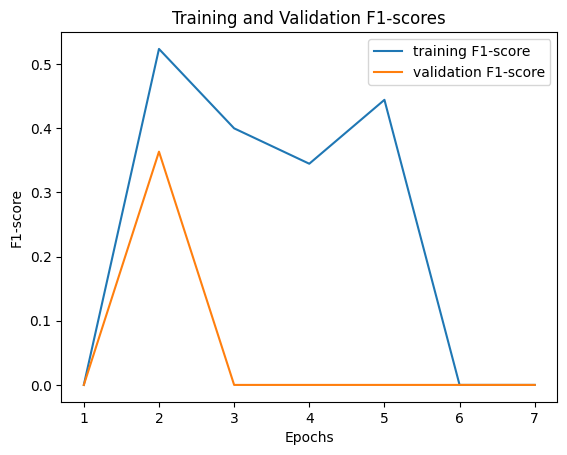

In [146]:
epochs = range(1, total_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_f1_per_epoch,label ='training F1-score')
ax.plot(epochs, val_f1_per_epoch, label = 'validation F1-score')
ax.set_title('Training and Validation F1-scores')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1-score')
ax.legend()
plt.show()

Load best model from checkpoint during training with early stopping

In [87]:
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint["model"])
model.to(device)

BertClassification(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-0

Make predictions

In [88]:
model.eval()
test_pred = []
actual_labels = []
test_loss = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        
        output = model(input_ids = input_ids, attention_mask=att_mask) #, labels= labels

        loss = nn.CrossEntropyLoss()(output, labels) #loss = output.loss #output[0]
        test_loss += loss.item()
   
        preds = np.argmax(output.cpu().detach().numpy(),axis=-1)
        test_pred+=list(preds)
        actual_labels+=labels.tolist()
        

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation on test set (unseen data)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      1.00      0.33         2

    accuracy                           0.20        10
   macro avg       0.10      0.50      0.17        10
weighted avg       0.04      0.20      0.07        10

Accuracy:20.00%
Precision:20.00%
Recall:100.00%
F1 score:33.33%
F2 score:55.56%
Roc_Auc score:50.00%
TP= 2
TN= 0
FP= 8
FN= 0


D:\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

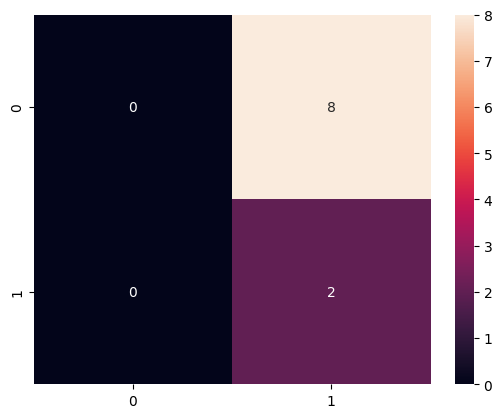

In [89]:
class_report = classification_report(actual_labels, test_pred)
print("Classification Report:\n", class_report)

total_test_loss = test_loss/len(test_dataloader) 
accuracy=accuracy_score(actual_labels, test_pred)
if n_categories > 2:
    precision=precision_score(actual_labels, test_pred, average='macro')
    recall=recall_score(actual_labels, test_pred, average='macro')
    f1=f1_score(actual_labels, test_pred, average='macro')
else:
    precision=precision_score(actual_labels, test_pred)
    recall=recall_score(actual_labels, test_pred)
    f1=f1_score(actual_labels, test_pred)
    roc_auc=roc_auc_score(actual_labels, test_pred)
f2 = (5*precision*recall) / (4*precision+recall)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))
if roc_auc:
    print("Roc_Auc score:%.2f%%"%(roc_auc*100))

conf_matrix = confusion_matrix(actual_labels, test_pred)
tn, fp, fn, tp = conf_matrix.ravel()
#acc = ((tp+tn)/(tp+tn+fp+fn))

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)
#print(conf_matrix)
sn.heatmap(conf_matrix, annot=True)

Export classification report

In [163]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(shuffle_seeder))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{shuffle_seeder}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [164]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method, str(shuffle_seeder))
for filename in os.listdir(results_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(results_folder, filename)
        with open(csv_file_path, "r", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for metric, value in row.items():
                    cumulative_metrics[metric] += float(value)
        count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)

{'accuracy': 0.2, 'precision': 0.2, 'recall': 1.0, 'f1': 0.33333333333333337, 'f2': 0.5555555555555556, 'roc_auc': 0.5}
